In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from parameters import read_params

from scipy.special import gamma
def myGamma(zeta):
    return gamma(1-1/zeta)

DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"

def pv(name, mat):
    print("{}: {}".format(name.rjust(10), mat.shape))

In [2]:
param = read_params()

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866

 skill1880: (645, 2)
  wage1880: (645, 2)
       Q_A: (645, 5)
      Q_NA: (645, 5)
         Z: (5, 2)
        vA: (5, 1)
   Capital: (5, 1)
       phi: (4, 1)
       tau: (645, 645)
 amenities: (645, 5)


## Define constants

In [3]:
def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

$$
r = R - \delta
$$

In [4]:
psi(param.r)

0.7655096595807223

In [5]:
myGamma(param.zeta)

2.3211529336709016

In [6]:
R = 3.63

In [7]:
# now this is just for the short names
skills, wages = param.skill1880, param.wage1880
Q_A, Q_NA = param.Q_A, param.Q_NA

Z, vA, Capital, phi = param.Z, param.vA, param.Capital, param.phi

tau, amenities = param.tau, param.amenities

## Mess with the variables a bit

In [8]:
# TODO MAKE 4 DIMENSIONS (time, skill, sector, region)

skills = np.expand_dims(skills, 2).transpose((2,1,0))
pv("skills", skills)

wages = np.expand_dims(wages, 2).transpose((2,1,0))
pv("wages", wages)

Q = np.stack((Q_A, Q_NA), axis=1).transpose((2,1,0))
pv("Q", Q)

vA = vA.flatten()
vAt= np.array([vA[1], 1-vA[1]]).reshape(2,1)
pv("vAt", vAt)

Capital = Capital.flatten()
pv("Capital", Capital)

pv("tau", tau)

amenities = amenities.transpose((1,0))
pv("amenities", amenities)

    skills: (1, 2, 645)
     wages: (1, 2, 645)
         Q: (5, 2, 645)
       vAt: (2, 1)
   Capital: (5,)
       tau: (645, 645)
 amenities: (5, 645)


In [34]:
# define some constants for indexing
t = 0
A, NA = 0,1
L, H = 0,1
R,S,T = 2,1,0

# Remember that Psi is indexed like Psi[L,A]
Psi = np.array([[1,1],
                [param.q, param.mu * param.q]])

# Define methods

In [10]:
# useful for resets
def readWages():
    wages = param.wage1880
    wages = np.expand_dims(wages, 2).transpose((2,1,0))
    wages = wages / np.sum(wages) # what if we normalize for fun
    return wages

def readSkills():
    skills = param.skill1880
    skills = np.expand_dims(skills, 2).transpose((2,1,0))
    return skills

In [11]:
def computePi(wages):
    """
    Parameters:
        wages - shape [time, Sectors, Regions]
        Q - shape [time, Sectors, Regions]
    
    Returns:
        pi has shape (1, 2, 645)
    """
    # Q is already raised**(sigma - 1)
    pi = Q[t] * wages**((1-param.alpha)*(1-param.sigma))
    
    # sum across regions
    normalize = np.sum(pi, axis=R)
    
    # normalize has shape (1,2), so we make it have shape (1,2,1)
    normalize = np.expand_dims(normalize, 2)
    pi = pi / normalize
    
    return pi

pi = computePi(wages)
np.sum(pi, axis=R)

array([[1., 1.]])

In [12]:
def computeTheta(wages):
    """
    196 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs)
    """
    Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
    Theta_l = Theta[0,L]
    Theta_h = Theta[0,H]
    return Theta_h, Theta_l

def computeTheta2(wages):
    """
    304 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs,
    """
    z = param.zeta
    Theta_h = (Psi[H,A]*(wages[t,A]**z) + Psi[H,NA]*(wages[t,NA]**z))**(1/z)
    Theta_l = (Psi[L,A]*(wages[t,A]**z) + Psi[L,NA]*(wages[t,NA]**z))**(1/z)
    return Theta_h, Theta_l

a,b = computeTheta(wages)
c,d = computeTheta2(wages)

np.sum(a-c), np.sum(b-d) # these are the same

(0.0, 0.0)

In [14]:
def computeLrt(skills):
    """
    Expects:
        skills[1,2,645]
        skills[0, L, :] == low-skilled populations across regions
    
    Returns:
        const_lambda - Lambda, 1-Lambda. This is constant throughout time
        totals - L. (portion of population in each region)
        skill_shares - share of high/low skill in each region. lambda_rt and 1-lambda_rt
        
    """
    const_lamda = np.sum(skills, axis=R)
    sums = np.sum(skills, axis=S)
    skill_shares = (skills/sums)
    return const_lamda, sums, skill_shares

def test_computeLrt(skills):
    const_lamda, sums, skill_shares = computeLrt(skills)

    print(const_lamda)
    print('L_rt sums to', np.sum(sums))
    
    x = np.sum(skill_shares, axis=S)
    print(np.allclose(x, np.ones_like(x)))
    
test_computeLrt(skills)

[[0.7046579  0.29534209]]
L_rt sums to 0.999999993419246
True


The majorit of commuting zones had agricultural employment shares exceeding 75% in 1880...

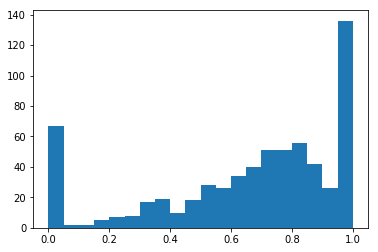

In [15]:
const_lamda, sums, skill_shares = computeLrt(skills)

plt.hist(skill_shares[t,A], bins=20)
plt.show()

In [16]:
np.sum(skills)

0.9999999934192461

In [17]:
skills, wages = readSkills(), readWages()

def computeGDP(skills, wages):
    """
    GDP is an actual number!
    """
    Theta_h, Theta_l = computeTheta(wages)
    
    constant= 1/(1-param.alpha) * myGamma(param.zeta)
    GDP = constant * np.sum((skills[t,H] * Theta_h + skills[t,L] * Theta_l))
    
    return GDP

computeGDP(skills, wages)

0.0034030779422166675

## Sectoral prices (and normalizing wages)

In [18]:
param.Z

array([[0.045844, 0.051099],
       [0.067368, 0.084494],
       [0.098668, 0.15938 ],
       [0.083907, 0.27512 ],
       [0.11267 , 0.48463 ]])

In [37]:
R_t = 3.63

In [38]:
Zt = param.Z[t]
Zt.shape

sector = NA

temp = Q[t,sector,0] * ((1/Zt[sector] * (wages[t,sector,0] / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha))**(1-param.sigma)
temp

5.881977582807274

In [39]:
x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
x = x.transpose((1,0))
x.shape

x[sector, 0]

5.881977582807274

In [40]:
prices = np.sum(x, axis=1)**(1/(1-param.sigma))
prices # P_A, P_NA

array([0.02388413, 0.04312021])

In [41]:
# and then we normalize it
normprices = prices/prices[0]
normprices

array([1.        , 1.80539147])

What price normalization means for wages:
$$
P_{At} = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \cdot P_{At}^{-1} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{ w_{Ajt} \cdot P_{At}^{-\frac{1}{1-\alpha}}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

Or equivalently:
$$
w_{new} = \frac{ w_{old}}{ P_{At}^{\frac{1}{1-\alpha}}}
$$

In [42]:
normwages = wages/(prices[0]**(1/(1-param.alpha)))
normwages

array([[[0.0299579 , 0.03178196, 0.03611341, ..., 0.06841253,
         0.10130349, 0.08424844],
        [0.01173056, 0.01164318, 0.00952227, ..., 0.0524142 ,
         0.08129671, 0.04365236]]])

In [44]:
# just be careful: if we do it this way, the wages will be great!
np.sum(normwages, axis=R)

array([[31.83960945, 19.12317556]])

## Putting it all together

In [47]:
vAt

array([[0.32289],
       [0.67711]])

In [147]:
def loopy(skills, wages, log=True):
    lr = 0.1
    loss = 10
    
    # these are fixed
    const_lamda, sums, skill_shares = computeLrt(skills)
    
    for i in range(1000):
        
        # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD
        Zt = param.Z[t]
        x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
        x = x.transpose((1,0))
        prices = np.sum(x, axis=1)**(1/(1-param.sigma))
        normprices = prices/prices[0]

        wages = wages/(prices[0]**(1/(1-param.alpha)))
        
        
        # compute the update
        pi = computePi(wages) # (1 by 2 by 645)
        Theta_h, Theta_l = computeTheta(wages) # (645,)
        GDP = computeGDP(skills, wages)
        
        #  labor market clearing conditions
        regionalRevenue = (1-param.alpha) * pi * vAt *  GDP
        
        # keeping this here as a reminder: NEVER WRITE UNCLEAR CODE
        # x = Lrt * myGamma(param.zeta) * np.matmul(lam_rt.transpose((2,0,1)), Psi).transpose((1,2,0))
        x = myGamma(param.zeta) * (skills[t,H] * Theta_h + skills[t,L] * Theta_l)
        
        newWages = regionalRevenue/x
    
        
        loss = np.sum(np.abs(newWages - wages))

        # update
        wages = lr * newWages + (1-lr) * wages
        
        if loss < 1e-6:
            if log:
                print('Iteration #{}: {}'.format(i, loss))
            break
            
        if i % 20 == 0 and log:
            print('Iteration #{}: {}'.format(i, loss))
            draw(wages)
            
    return wages


Iteration #0: 1.7640623775563204
Iteration #20: 0.06009778056446809
Iteration #40: 0.001531906136750253
Iteration #60: 0.00010956555656220771
Iteration #80: 1.2998024207177322e-05
Iteration #100: 1.5741983260652115e-06
Iteration #105: 9.295020922301195e-07


Text(0,0.5,'log Non-Agricultural wages')

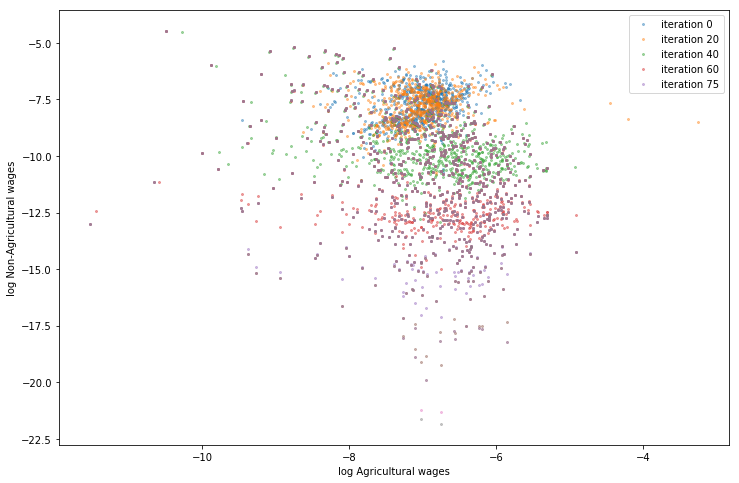

In [129]:
wages = readWages()
plt.figure(figsize=(12,8))

# before
draw(wages, log=True)

newWages = loopy(skills, wages)

# after
draw(newWages, log=True)
# plt.legend(['before', 'after'])
plt.legend(['iteration {}'.format(i) for i in [0,20,40,60,75]])
plt.xlabel('log Agricultural wages'); plt.ylabel('log Non-Agricultural wages')

This is the plot that I'm not sure about. Are the wages for Non-Agricultural sectors supposed to be bunched near 0?

## Incorporating mobility

In [130]:
def newLocations(wages):
    _,_,Theta = computeTheta(wages)    
    expectedUtility = myGamma(param.zeta)*Theta
    
    aa = myGamma(param.eta/param.zeta)/param.eta
    bb = consumption_share**(param.eta-1)
    
    # since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
    W_rt = aa*bb * expectedUtility**param.eta + amenities[1] # amenities in 1910

    # tau is indexed like j x r
    stuff = np.expand_dims(W_rt, 2) - tau

    sums = np.sum(np.exp(1/param.kappa * stuff), axis=3) # across the R's, not the j's
    sums = np.expand_dims(sums, 3)

    movingProbs = np.exp(1/param.kappa * stuff)/sums 
    oldL = np.expand_dims((Lrt*lam_rt), axis=3)
    new = np.sum(movingProbs * oldL, axis=2)
    
    return new

newSkills = newLocations(wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

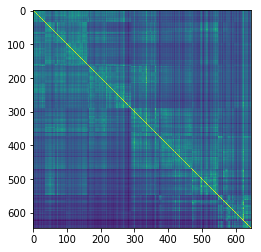

In [190]:
_,_,Theta = computeTheta(wages)    
expectedUtility = myGamma(param.zeta)*Theta

aa = myGamma(param.eta/param.zeta)/param.eta
bb = consumption_share**(param.eta-1)

# since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
W_rt = aa*bb * expectedUtility**param.eta + amenities[1] # amenities in 1910

# tau is indexed like j x r
stuff = np.expand_dims(W_rt, 2) - tau

sums = np.sum(np.exp(1/param.kappa * stuff), axis=3) # across the R's, not the j's
sums = np.expand_dims(sums, 3)

movingProbs = np.exp(1/param.kappa * stuff)/sums 
plt.imshow(movingProbs[t,H]**0)

L---- #0: 0.31771322213965264
L---- #7: 1.389311412897283e-08
0.6945664882659912 seconds


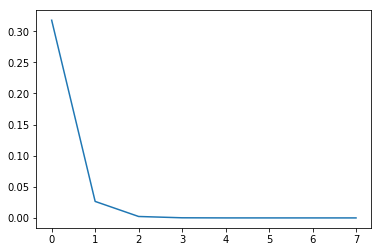

In [131]:
import time

wages  = readWages()
skills = readSkills()

start = time.time()

lr = 0.9
losses = []
for i in range(1000):
    
    # find a fixed point wage, given location
    wages = loopy(skills, wages, log=False)
    
    # find the new locations, given the wage
    newSkills = newLocations(wages)
    
    loss = np.sum(np.abs(newSkills - skills))
    losses.append(loss)
    
    skills = lr * newSkills + (1-lr)*skills
    
    if loss < 1e-7:
        print('L---- #{}: {}'.format(i, loss))
        break
    
    if i % 10 == 0:
        print('L---- #{}: {}'.format(i, loss))
        
print(time.time() - start, 'seconds')
plt.plot(losses)

## now we are going to test the conditions

In [132]:
pi = computePi(wages)
Theta_h, Theta_l, Theta = computeTheta(wages)
GDP = computeGDP(skills, wages)
print('GDP:', GDP)

GDP: 0.014476091697132322


In [133]:
regionalRevenue = (1-param.alpha) * pi * vAt *  GDP
x = Lrt * myGamma(param.zeta) * np.matmul(lam_rt.transpose((2,0,1)), Psi).transpose((1,2,0))


Text(0,0.5,'log high-skill')

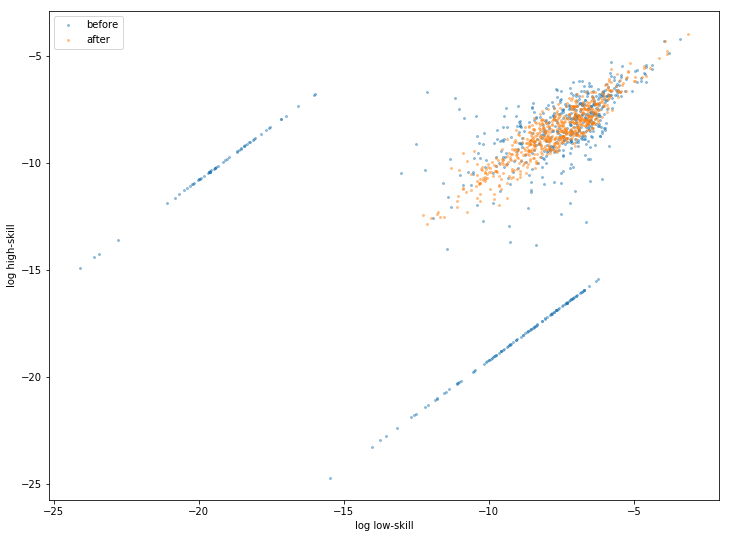

In [134]:
oldSkills = readSkills()
plt.figure(figsize=(12,9))

draw(oldSkills)
draw(skills)
plt.legend(['before', 'after'])
plt.xlabel('log low-skill'); plt.ylabel('log high-skill')

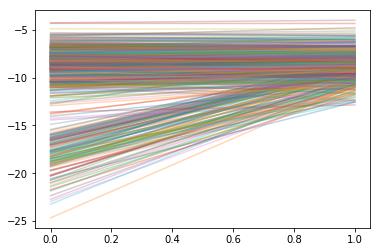

In [135]:
# plt.figure(figsize=(12,9))
plt.plot(np.log(np.array([oldSkills[0,NA], newSkills[0,NA]])), alpha=.3)
plt.show()

Text(0,0.5,'log Non-Agricultural wages')

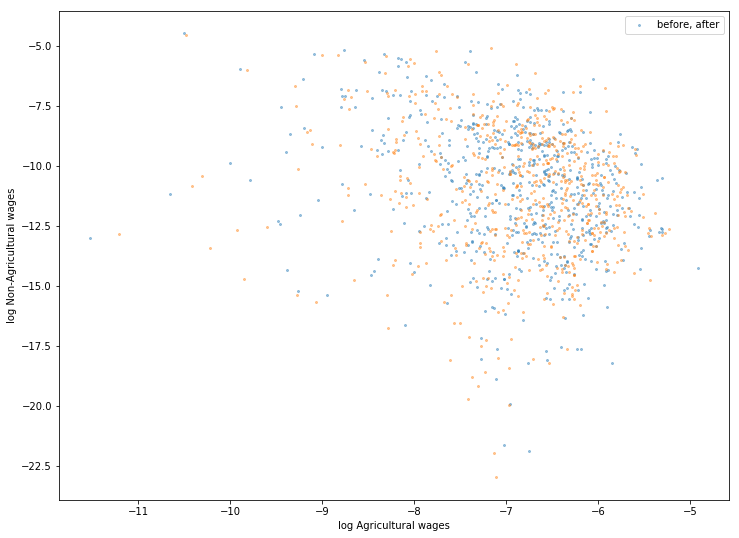

In [136]:
plt.figure(figsize=(12,9))

draw(newWages) # way back when... before we updated locations
draw(wages) # this is the actual result
plt.legend(['before, after'])
plt.xlabel('log Agricultural wages'); plt.ylabel('log Non-Agricultural wages')

In [137]:
# we don't any new wages with this location
nex = loopy(skills, wages)

Iteration #0: 4.3836361751479905e-07


In [138]:
# and we don't get any new locations either
locs = newLocations(nex)

# the new locations and the one we get are the same
np.sum(np.abs(locs - skills))

3.285505358783117e-09

They definitely converged... 

## Are these the 1910 wages and locations?

## Checks

In [139]:
newSkills = newLocations(wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

In [140]:
np.sum(wages) # wages must sum to 1

1.0000000000000002

In [141]:
np.sum(wages, axis=R) # just curious

array([[0.86491004, 0.13508996]])

since 
$$
K_{t+1} = (1-\psi(r_{t+1}) (1-\alpha) PY_t
$$

we have:

$$
R_1 K_1 = \alpha PY_1
$$

Or:
$$
R_1 (1-\psi(r_1))(1-\alpha) PY_0 = \alpha PY_1
$$

Thus:
$$
(r_1 + \delta) (1-\psi(r_1))  = \frac{\alpha PY_1}{(1-\alpha) PY_0}
$$


In [148]:
# 1880 wages and locations
oldSkills, oldWages = readSkills(), readWages()
GDP_0 = computeGDP(oldSkills, oldWages)

# 1910 wages and locations
GDP_1 = computeGDP(skills, wages)

# right hand side
const = param.alpha / (1-param.alpha) * (GDP_1 / GDP_0)
const

0.10677140699536947

In [143]:
interest_rate = param.r/100

(interest_rate + param.delta) * (1-psi(interest_rate))

0.12332951091056227

Text(0,0.5,'log manufacturing earnings 1910')

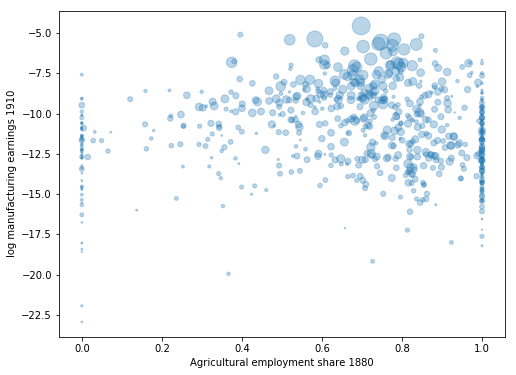

In [144]:
# Figure 3 in the paper
# agricultural employment share 1880 vs log Manufacturing earnings 1910

lamda, Lrt, lam_rt = computeLrt(oldSkills) # 1880
sizes = np.floor(Lrt[0]**0.6 * 2000)

plt.figure(figsize=(8,6))
plt.scatter(lam_rt[t,A], np.log(wages[t,NA]), alpha=0.3, s=sizes)
plt.xlabel('Agricultural employment share 1880')
plt.ylabel('log manufacturing earnings 1910')

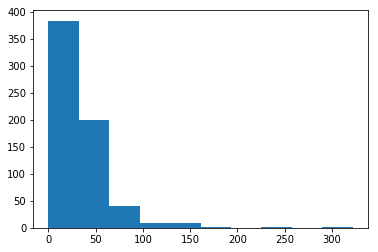

In [145]:
_ = plt.hist(sizes)

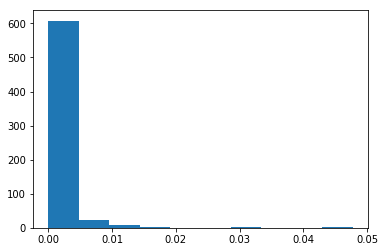

In [146]:
_ = plt.hist(Lrt[0])

In [66]:
plot_params = {
    'alpha': 0.4,
    's': 4
}

def draw(wages, log=True):
    
    if log:
        plt.scatter(np.log(wages[t,A]), np.log(wages[t,NA]),
           **plot_params)
    else:
        plt.scatter(wages[t,A], wages[t,NA],
           **plot_params)

def plotANA(x):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(x[t,A])

    plt.subplot(1,2,2)
    plt.plot(x[t,NA])

doesn't look right to me!!